# Topic Coherence Evaluation

In [109]:
from csv import reader

import re
import numpy as np
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt

def visualize_coherence(save_path, coherence_scores, title, labels, colors, start, limit, step):
        """
        Function to display num_topics - topic coherence coherence

        Parameters:
        ----------
        save_path : path to save image
        coherence_score : list of coherence scores
        title : graph title
        metric_label : topic coherence metric label
        color : color of plot
        start : starting index of topics
        limit : end index of topics
        step : step for topics
        Returns:
        -------
        """

        print('INFO: creating evalution visualization')  
        # Show graph
        

        
        x = range(start, limit, step)
        
        if len(coherence_scores) == 1:
            m, b = np.polyfit(x, coherence_scores[0], 1)

            # line of best fit
            plt.plot(x, m*x + b, color='orange')
        
        # plot data
        figs = []
        for i in range(len(coherence_scores)):
            
            figs.append(plt.plot(x, coherence_scores[i], label=labels[i], linestyle='none', marker='o', color=colors[i]))
        
        
        plt.suptitle(title)
        plt.xlabel("Number of Topics")
        plt.ylabel("Coherence Score")
        plt.legend(loc='best', borderpad=1)
        
        plt.savefig(save_path)
        
        plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')

        plt.show()



# function to tokenize the unstructured text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations    

'''
fn to get topic coherence from a list of topics

topics: list of topics
texts: the raw text corpus
id2word: the gensim corpora dictionary
coherence: the gensim coherence metric
'''
def get_coherence_score(topics, texts, id2word, coherence='umass'):
    
    corpus = [id2word.doc2bow(tok) for tok in texts]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=id2word, coherence=coherence)
    
    coherence_model_score = coherence_model.get_coherence()
    return coherence_model_score


def generate_coherence_score(data_file_path, topic_path_prefix, num_topics_list):
    '''
    generate_coherence_score

    this fn will generate a tuple of the umass and uci coherence scores over a number of topics
    for a topic model

    @data_file_path: the path to the raw data that will be used to score the coherence of a model

    @topic_path_prefix: this paramater is a string that represents the prefix that will be used to open the topics for each model: 
        needs to fit the pattern ^'../results/lsi/descriptions/lsi-description-'$, the suffix
        is the same for all of the model results and will be appended with a hardcoded string 
        <num_topic>topics.txt

    @num_topics_list: this parameter is a list of integers for the number of topics that were generated for a models results

    '''
    with open(data_file_path) as d:
        data_lines = []
        
        # break the data file up into tokens
        for line in d.readlines():
            line = re.sub('\n', '', line)
            data_lines.append(line)
        


        umass_coherence = []
        uci_coherence = []

        for k in num_topics_list:

            with open(topic_path_prefix + str(k) + 'topics.txt') as f:
                
                topics = []
                for line in f.readlines():
                    words = []
                    for word in line.split():
                        word = re.sub(',', '', word)
                        words.append(word)
                    topics.append(words)

                data_tokens = list(sent_to_words(data_lines))

                # generate id2word dictionary of bigrams
                id2word = corpora.Dictionary(data_tokens)


                # generate corpus from bigrams
                corpus = [id2word.doc2bow(tok) for tok in data_tokens]
                umass = get_coherence_score(topics, data_tokens, id2word, 'u_mass')
                uci = get_coherence_score(topics, data_tokens, id2word, 'c_uci')

                umass_coherence.append(umass)
                uci_coherence.append(uci)
        print('INFO finished generating coherence ' +
              ' scores for raw data: {} and model results: {}'.format(data_file_path, topic_path_prefix))
        return (umass_coherence, uci_coherence)


# Model Evaluation

This section will analyze the performance of the different topic models

### LSI Topic Coherence Generation

In [10]:
desc_title_num_topics = [ 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100 ]

print('INFO: generating description coherence scores for lsi')
lsi_description_tc =  generate_coherence_score(
                        'datasets/parsed_full_descriptions.txt',
                        '../results/lsi/descriptions/lsi-description-',
                        desc_title_num_topics
                      )

print(lsi_description_tc, end='\n\n\n')

print('INFO: generating title coherence scores for lsi')
lsi_title_tc =     generate_coherence_score(
                        'datasets/parsed_full_titles.txt',
                        '../results/lsi/titles/lsi-title-',
                        desc_title_num_topics
                    )
print(lsi_title_tc)

INFO: generating description coherence scores for lsi
INFO finished generating coherence  scores for raw data: datasets/parsed_full_descriptions.txt and model results: ../results/lsi/descriptions/lsi-description-
([-5.859218389198672, -4.984199885524811, -6.463798966187267, -5.370840153383402, -5.50472850739282, -6.197304829912619, -7.093451609706482, -7.416171175002037, -8.00826951199404, -8.43862590251067, -8.833071545405746, -8.870775741487849, -9.790131650344838, -9.749046920089425, -10.413961778872778, -10.697492507042126, -10.873294342901117, -11.292425756134497, -11.394802195954421], [-3.0870547217721507, -2.5455266509139913, -3.72998111443993, -2.8002704424961853, -3.0681807862679507, -3.892032373033842, -4.734611643405903, -5.036511610875596, -5.461923310020906, -5.7530884529040875, -6.17918330722027, -6.191108232961799, -6.880143141814902, -6.872615323737267, -7.567446176648042, -7.795144712439777, -7.913459532377886, -8.359394760971599, -8.325340406699086])


INFO: generatin

### LDA Topic Coherence

In [4]:
desc_title_num_topics = [ 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100 ]

print('INFO: generating description coherence scores for lda')
lda_description_tc =  generate_coherence_score(
                        'datasets/parsed_full_descriptions.txt',
                        '../results/lda/descriptions/lda-description-',
                        desc_title_num_topics
                      )

print(lda_description_tc, end='\n\n\n')

print('INFO: generating title coherence scores for lda')
lda_title_tc =     generate_coherence_score(
                        'datasets/parsed_full_titles.txt',
                        '../results/lda/titles/lda-title-',
                        desc_title_num_topics
                    )
print(lda_title_tc)

INFO: generating description coherence scores for lda
INFO finished generating coherence  scores for raw data: datasets/parsed_full_descriptions.txt and model results: ../results/lda/descriptions/lda-description-
([-5.028548924823591, -4.981829120431677, -5.499736333744547, -6.043571461032274, -5.72841690077783, -6.3935827767815185, -6.402413922864028, -6.353051496513843, -7.370888455877525, -7.1164725422313255, -7.10799903662323, -7.066907110560028, -7.887359477381855, -7.674803017290013, -7.9190551637725175, -8.869428325878351, -8.374210764233796, -8.35394497567882, -9.127348345009691], [-2.108276445931396, -2.166281233489007, -2.684780237083479, -3.063227683605237, -2.859622226997287, -3.3251450756960064, -3.4620101649926567, -3.189251785816026, -4.0982079438716825, -3.905300859857621, -3.846467103342639, -3.781289338544121, -4.546839809128515, -4.204886795719195, -4.410185436342408, -5.256607535773454, -4.76852255326634, -4.7552571864611854, -5.264392520725603])


INFO: generating 

# ETM Topic Coherence

In [26]:
desc_title_num_topics = [ 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100 ]

print('INFO: generating description coherence scores for etm')
etm_description_tc =  generate_coherence_score(
                        'datasets/parsed_full_descriptions.txt',
                        '../results/etm/descriptions/description-etm-',
                        desc_title_num_topics
                      )

print(etm_description_tc, end='\n\n\n')

print('INFO: generating title coherence scores for etm')
etm_title_tc =     generate_coherence_score(
                        'datasets/parsed_full_titles.txt',
                        '../results/etm/titles/title-etm-',
                        desc_title_num_topics
                    )
print(etm_title_tc)

INFO: generating description coherence scores for etm
INFO finished generating coherence  scores for raw data: datasets/parsed_full_descriptions.txt and model results: ../results/etm/descriptions/description-etm-
([-5.535945204532871, -5.1763433109676384, -4.523123539084188, -5.693011882911394, -5.538413099033175, -5.352027384793378, -5.590688378840148, -5.18265627730716, -5.182670266156553, -5.209332137100639, -4.52897376169601, -5.0191108466012055, -5.053149715244237, -5.267712625181472, -5.130493719424554, -5.35592894947335, -5.104480661780863, -5.386202432245379, -5.1188266927645785], [-2.5173661638047475, -2.330320461907496, -1.582907094491389, -2.7753202725037625, -2.653778920470622, -2.3329674293266707, -2.60304620830147, -2.271428370405957, -2.2589604951257884, -2.360780897586848, -1.724257524877004, -2.0930303000190604, -2.0568828967442347, -2.3083674892657333, -2.1995508884267947, -2.489945451778978, -2.224817140761242, -2.5299141164851577, -2.2817638354418515])


INFO: gener

# Visualize Description Topic Coherence

INFO: creating evalution visualization


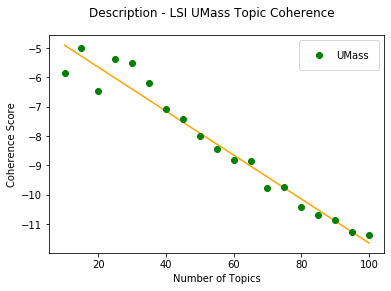

<Figure size 1000x600 with 0 Axes>

In [85]:
visualize_coherence(
    'results_figures/lsi/description/lsi-umass-description.png',
    [lsi_description_tc[0]],
    'Description - LSI UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)


INFO: creating evalution visualization


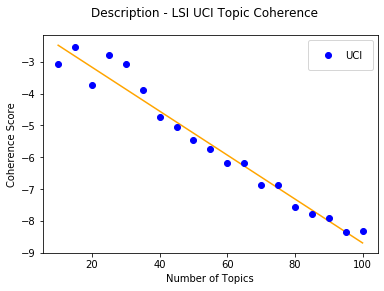

<Figure size 1000x600 with 0 Axes>

In [86]:
visualize_coherence(
    'results_figures/lsi/description/lsi-uci-description.png',
    [lsi_description_tc[1]],
    'Description - LSI UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)

INFO: creating evalution visualization


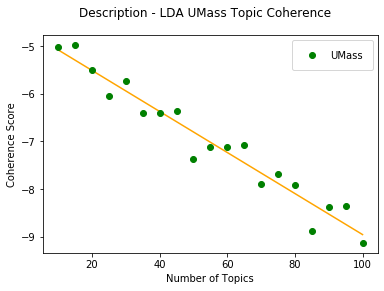

<Figure size 1000x600 with 0 Axes>

In [90]:
visualize_coherence(
    'results_figures/lda/description/lda-umass-description.png',
    [lda_description_tc[0]],
    'Description - LDA UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)


INFO: creating evalution visualization


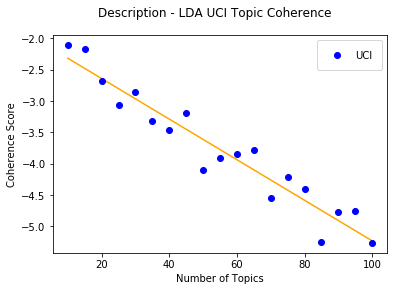

<Figure size 1000x600 with 0 Axes>

In [91]:
visualize_coherence(
    'results_figures/lda/description/lda-uci-description.png',
    [lda_description_tc[1]],
    'Description - LDA UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)


INFO: creating evalution visualization


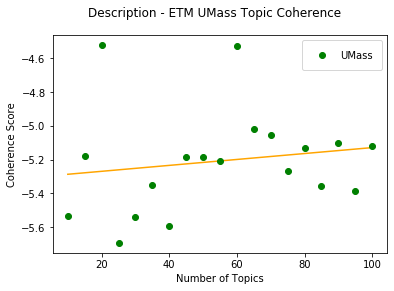

<Figure size 1000x600 with 0 Axes>

In [72]:
visualize_coherence(
    'results_figures/etm/description/etm-umass-description.png',
    etm_description_tc[0],
    'Description - ETM UMass Topic Coherence',
    ['UMass'],
    'green',
    10,
    105,
    5
)


INFO: creating evalution visualization


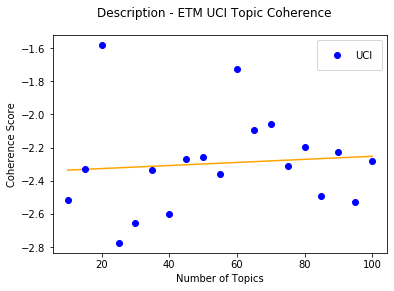

<Figure size 1000x600 with 0 Axes>

In [73]:
visualize_coherence(
    'results_figures/etm/description/etm-uci-description.png',
    etm_description_tc[1],
    'Description - ETM UCI Topic Coherence',
    ['UCI'],
    'blue',
    10,
    105,
    5
)


### Description Comparison

INFO: creating evalution visualization


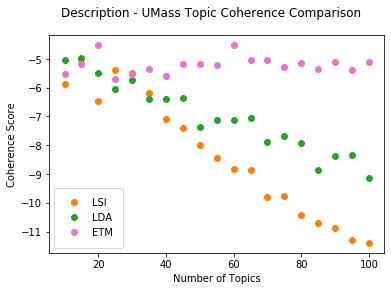

<Figure size 1000x600 with 0 Axes>

In [112]:
visualize_coherence(
    'results_figures/combined/umass-description.png',
    [lsi_description_tc[0], lda_description_tc[0], etm_description_tc[0]],
    'Description - UMass Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM'],
    ['tab:orange', 'tab:green', 'tab:pink'],
    10,
    105,
    5
)

INFO: creating evalution visualization


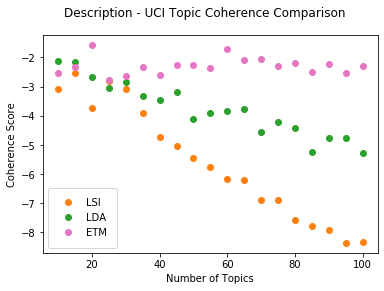

<Figure size 1000x600 with 0 Axes>

In [113]:
visualize_coherence(
    'results_figures/combined/uci-description.png',
    [lsi_description_tc[1], lda_description_tc[1], etm_description_tc[1]],
    'Description - UCI Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM'],
    ['tab:orange', 'tab:green', 'tab:pink'],
    10,
    105,
    5
)

# Title

INFO: creating evalution visualization


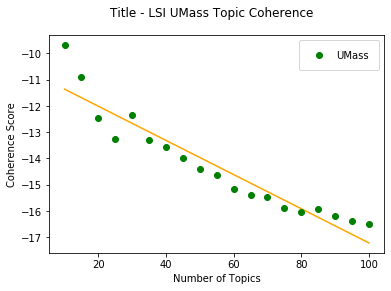

<Figure size 1000x600 with 0 Axes>

In [87]:
visualize_coherence(
    'results_figures/lsi/title/lsi-umass-title.png',
    [lsi_title_tc[0]],
    'Title - LSI UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)


INFO: creating evalution visualization


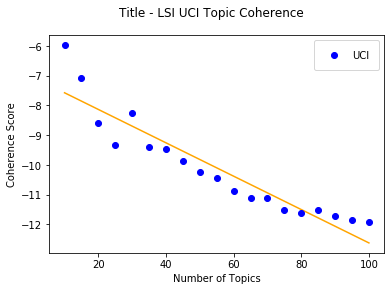

<Figure size 1000x600 with 0 Axes>

In [88]:
visualize_coherence(
    'results_figures/lsi/title/lsi-uci-title.png',
    [lsi_title_tc[1]],
    'Title - LSI UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)


INFO: creating evalution visualization


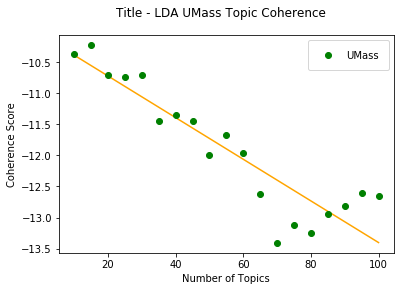

<Figure size 1000x600 with 0 Axes>

In [92]:
visualize_coherence(
    'results_figures/lda/title/lda-umass-title.png',
    [lda_title_tc[0]],
    'Title - LDA UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)


INFO: creating evalution visualization


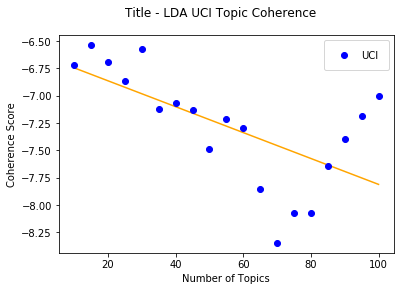

<Figure size 1000x600 with 0 Axes>

In [93]:
visualize_coherence(
    'results_figures/lda/title/lda-uci-title.png',
    [lda_title_tc[1]],
    'Title - LDA UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)

INFO: creating evalution visualization


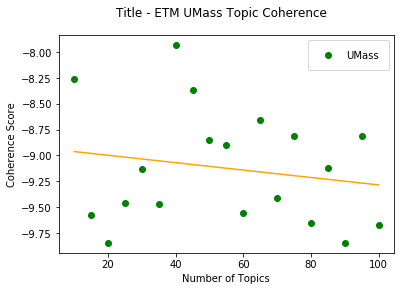

<Figure size 1000x600 with 0 Axes>

In [74]:
visualize_coherence(
    'results_figures/etm/title/etm-umass-title.png',
    etm_title_tc[0],
    'Title - ETM UMass Topic Coherence',
    ['UMass'],
    'green',
    10,
    105,
    5
)


INFO: creating evalution visualization


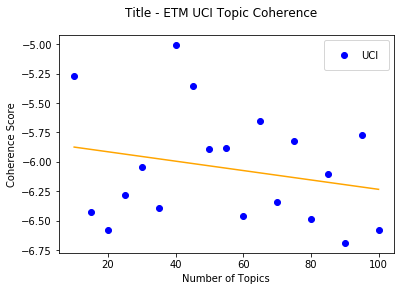

<Figure size 1000x600 with 0 Axes>

In [75]:
visualize_coherence(
    'results_figures/etm/title/etm-uci-title.png',
    etm_title_tc[1],
    'Title - ETM UCI Topic Coherence',
    ['UCI'],
    'blue',
    10,
    105,
    5
)


### Title Comparison

INFO: creating evalution visualization


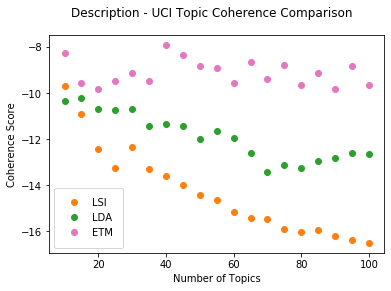

<Figure size 1000x600 with 0 Axes>

In [116]:
visualize_coherence(
    'results_figures/combined/umass-title.png',
    [lsi_title_tc[0], lda_title_tc[0], etm_title_tc[0]],
    'Description - UCI Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM'],
    ['tab:orange', 'tab:green', 'tab:pink'],
    10,
    105,
    5
)

INFO: creating evalution visualization


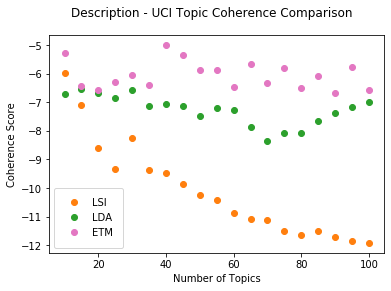

<Figure size 1000x600 with 0 Axes>

In [117]:
visualize_coherence(
    'results_figures/combined/uci-title.png',
    [lsi_title_tc[1], lda_title_tc[1], etm_title_tc[1]],
    'Description - UCI Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM'],
    ['tab:orange', 'tab:green', 'tab:pink'],
    10,
    105,
    5
)

# Dataset comparisons

### LSI

INFO: creating evalution visualization


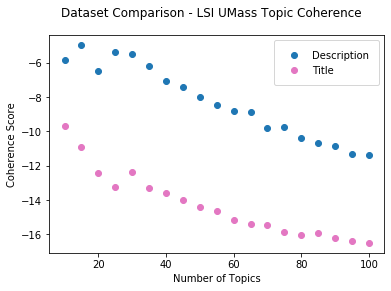

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


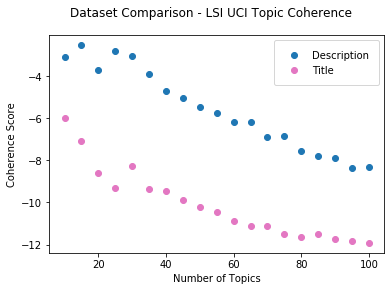

<Figure size 1000x600 with 0 Axes>

In [130]:

visualize_coherence(
    'results_figures/lsi/lsi-umass-dataset-comparison.png',
    [lsi_description_tc[0], lsi_title_tc[0]],
    'Dataset Comparison - LSI UMass Topic Coherence',
    ['Description', 'Title'],
    ['tab:blue', 'tab:pink'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lsi/lsi-uci-dataset-comparison.png',
    [lsi_description_tc[1], lsi_title_tc[1]],
    'Dataset Comparison - LSI UCI Topic Coherence',
    ['Description', 'Title'],
    ['tab:blue', 'tab:pink'],
    10,
    105,
    5
)

### LDA 

INFO: creating evalution visualization


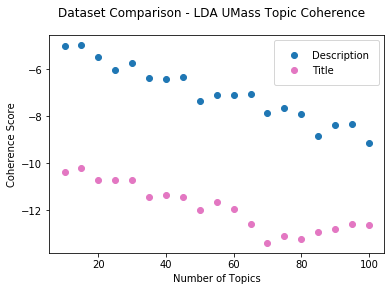

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


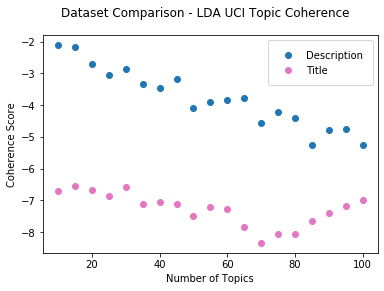

<Figure size 1000x600 with 0 Axes>

In [131]:

visualize_coherence(
    'results_figures/lda/lda-umass-dataset-comparison.png',
    [lda_description_tc[0], lda_title_tc[0]],
    'Dataset Comparison - LDA UMass Topic Coherence',
    ['Description', 'Title'],
    ['tab:blue', 'tab:pink'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda/lda-uci-dataset-comparison.png',
    [lda_description_tc[1], lda_title_tc[1]],
    'Dataset Comparison - LDA UCI Topic Coherence',
    ['Description', 'Title'],
    ['tab:blue', 'tab:pink'],
    10,
    105,
    5
)

INFO: creating evalution visualization


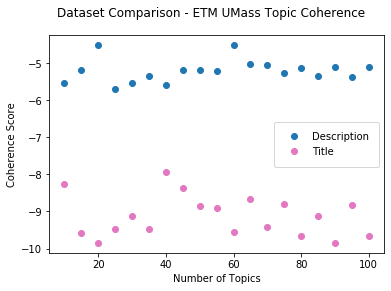

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


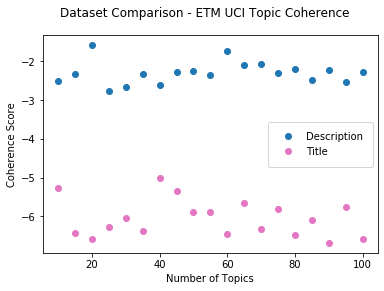

<Figure size 1000x600 with 0 Axes>

In [132]:

visualize_coherence(
    'results_figures/etm/etm-umass-dataset-comparison.png',
    [etm_description_tc[0], etm_title_tc[0]],
    'Dataset Comparison - ETM UMass Topic Coherence',
    ['Description', 'Title'],
    ['tab:blue', 'tab:pink'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/etm/etm-uci-dataset-comparison.png',
    [etm_description_tc[1], etm_title_tc[1]],
    'Dataset Comparison - ETM UCI Topic Coherence',
    ['Description', 'Title'],
    ['tab:blue', 'tab:pink'],
    10,
    105,
    5
)